<a href="https://colab.research.google.com/github/yassmin1/311_services_city_SATX/blob/main/311_SA_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML model


## Outlines

**Data Preprocessing:**     


* Encode categorical variables (Category, Dept, REASONNAME, TYPENAME, CaseStatus, SourceID, District) using techniques like one-hot encoding.
* Drop unnecessary columns like CASEID, XCOORD, YCOORD


**Feature Engineering**:   

Create new features from date columns such as day of the week, month, and hour.
Extract information from text columns if relevant (e.g., text length, word count).
Normalize or scale numerical features if necessary.     
**Splitting Data:**     

Split the dataset into training and testing sets. The target variable will be Late.      
**Model Selection:**  

Choose appropriate machine learning algorithms for classification, such as Random Forest, Gradient Boosting, Logistic Regression, etc.
Perform hyperparameter tuning using techniques like grid search or random search to optimize model performance.     
**Model Training:**  

Train the selected model(s) on the training data.      
**Model Evaluation:**    

Evaluate the trained model(s) on the testing data using metrics like accuracy, precision, recall, F1-score, and ROC-AUC score.      
**Pipeline Construction:**     

Build a machine learning pipeline using scikit-learn's Pipeline class to streamline the preprocessing and modeling steps.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report,roc_curve,auc


In [ ]:
# Load the dataset
input="/content/drive/MyDrive/SanAntonioCity311/311_data_lat_lon.csv"
df = pd.read_csv(input)
print(df.shape)
print(df.columns)

(575079, 28)
Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'Category', 'CASEID',
       'OPENEDDATETIME', 'SLA_Date', 'CLOSEDDATETIME', 'Late', 'Dept',
       'REASONNAME', 'TYPENAME', 'CaseStatus', 'SourceID', 'OBJECTDESC',
       'Council_District', 'XCOORD', 'YCOORD', 'time_interval',
       'time_interval_quantiles', 'holidays', 'rain', 'tavg_f', 'lat', 'lon',
       'month', 'year', 'day_of_week'],
      dtype='object')


In [ ]:
# filter data to 2023 andd 2024
df=df[df.year>=2023]

In [ ]:
# new features
df['month']=pd.DatetimeIndex(df['OPENEDDATETIME']).month.astype(object)
df['year']=pd.DatetimeIndex(df['OPENEDDATETIME']).year.astype(object)
df['day_of_week']=pd.DatetimeIndex(df['OPENEDDATETIME']).dayofweek.astype(object)

In [ ]:

df=df[['Category', 'SourceID','Council_District',
             'lat','lon','day_of_week','month','year','Late','holidays',
       'rain', 'tavg_f']].copy()




In [ ]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator=RandomForestClassifier()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier (default is RandomForestClassifier)
        """

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)


## Building pipline to find the model and parameters.

In [ ]:


# Define preprocessing steps for numerical and categorical columns
numeric_features = ['tavg_f']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_features = ['Category', 'Council_District',
          'day_of_week','month','SourceID','rain','holidays']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', RandomForestClassifier())])

# Define parameters for grid search
parameters = [
    {
        'model': [RandomForestClassifier(random_state=42)],
        'model__n_estimators': [100, 200, 300],  # Number of trees in the forest
        'model__max_depth': [3, 10, 20],  # Maximum depth of the tree
        #'model__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        #'model__max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
        },
    {
        'model': [XGBClassifier(random_state=42)],
        'model__n_estimators': [100, 200, 300],  # Number of trees in the ensemble
        'model__max_depth': [3, 5, 7],  # Maximum depth of a tree
        #'model__learning_rate': [0.1, 0.01, 0.001],  # Learning rate (shrinkage)
        #'model__min_child_weight': [1, 3, 5],  # Minimum weight of a child node
        #'model__subsample': [0.8, 0.9, 1.0],  # Fraction of the training set to use for training each tree
    }
]

In [ ]:
df[numeric_features]=df[numeric_features].astype(float)
df[categorical_features]=df[categorical_features].astype(object)
#
# Define features and target variable
features = ['Category', 'day_of_week','month', 'Council_District',
            'SourceID', 'holidays','rain','tavg_f']
target = 'Late'
# Split the dataset into features and target variable
X = df[features]
y = df[target].replace({'YES': 1, 'NO': 0})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [ ]:

# Perform grid search
gscv = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, return_train_score=False, scoring='roc_auc',verbose=3)
gscv.fit(X_train, y_train)


In [ ]:
print(gscv.best_estimator_)
print('Best parameters:', gscv.best_params)

In [ ]:
 gscv.best_estimator_['model']

## Cross Validation

In [ ]:
# choose the model and apply corss_validation
# Create the pipeline
#model = gscv.best_estimator_['model']
parm={'learning_rate': 0.1, 'max_depth': 7,
'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9,'nthread':4,}
    #  ,'tree_method':'gpu_hist',
    #'predictor':'gpu_predictor'}
model=XGBClassifier(**parm )

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
# Apply cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc',n_jobs=-1)

# Fit the pipeline on the entire dataset
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_train)
y_pred_proba = pipeline.predict_proba(X_train)[:, 1]






0


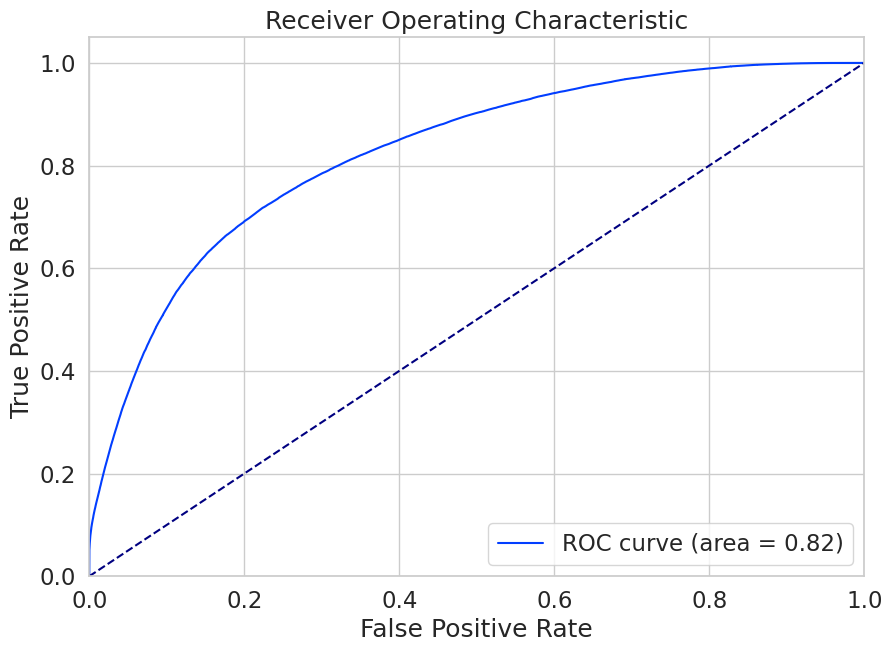

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
print(round(np.argmax(thresholds),2))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Find the threshold corresponding to the point closest to the top-left corner (0, 1)

distance_to_corner = np.sqrt((1 - tpr)**2 + fpr**2)
optimal_idx = np.argmin(distance_to_corner)
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold:", optimal_threshold)

Optimal Threshold: 0.14128679


In [ ]:
chosen_threshold = optimal_threshold  # Example threshold
predicted_classes = (y_pred_proba >= chosen_threshold).astype(int)
print(confusion_matrix(y_train,predicted_classes))
print(classification_report(y_train,predicted_classes))


[[254322  84021]
 [ 16633  47579]]
              precision    recall  f1-score   support

           0       0.94      0.75      0.83    338343
           1       0.36      0.74      0.49     64212

    accuracy                           0.75    402555
   macro avg       0.65      0.75      0.66    402555
weighted avg       0.85      0.75      0.78    402555



<Axes: >

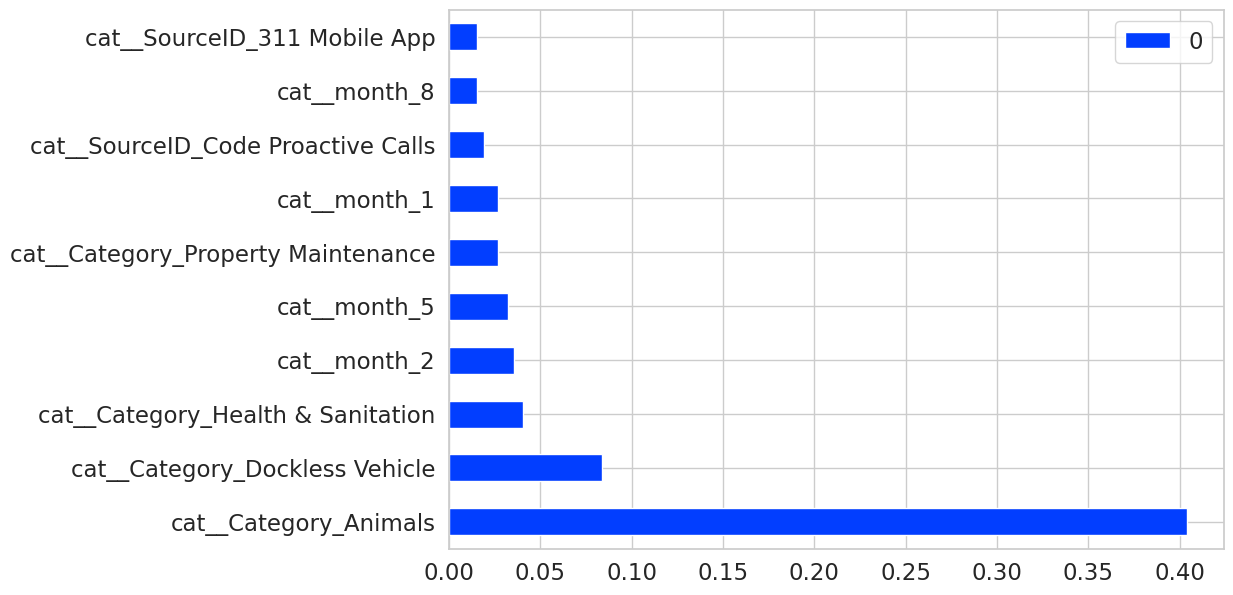

In [ ]:
df_imp=pd.DataFrame(dict(zip(pipeline.named_steps['preprocessor'].get_feature_names_out(),
                      pipeline.named_steps['model'].feature_importances_)),index=[0])
df_imp.T.sort_values(by=0,ascending=False)[:10].plot.barh()

0


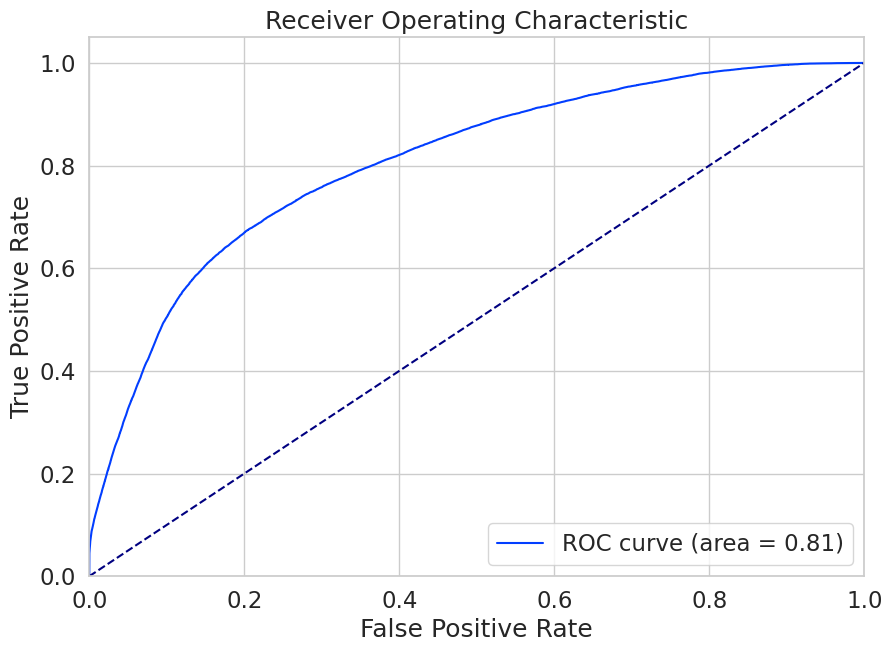

In [ ]:
# test
# Make predictions
y_pred_test = pipeline.predict(X_test)
y_pred_proba_test = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
print(np.argwhere(np.max(thresholds)))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Find the threshold corresponding to the point closest to the top-left corner (0, 1)

distance_to_corner = np.sqrt((1 - tpr)**2 + fpr**2)
optimal_idx = np.argmin(distance_to_corner)
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold:", optimal_threshold)

Optimal Threshold: 0.14126773


In [ ]:
chosen_threshold = optimal_threshold  # Example threshold
predicted_classes = (y_pred_proba_test >= chosen_threshold).astype(int)
print(confusion_matrix(y_test,predicted_classes))
print(classification_report(y_test,predicted_classes))

[[108100  37063]
 [  7601  19760]]
              precision    recall  f1-score   support

           0       0.93      0.74      0.83    145163
           1       0.35      0.72      0.47     27361

    accuracy                           0.74    172524
   macro avg       0.64      0.73      0.65    172524
weighted avg       0.84      0.74      0.77    172524



# save the file as html

In [ ]:
from google.colab import files
!pip install nbconvert
import os

In [ ]:
## Get all filenames in the current directory
filenames = os.listdir('.')

# Find the index of '311.ipynb' in the list
ipynb_index = filenames.index('SA_city_311.ipynb')
print(ipynb_index)
# Get the filename of '311.ipynb'
file0 = filenames[ipynb_index]

!jupyter nbconvert --to html {file0}
#files.download(file0[:-5] + ".html")
files.download(file0[:-5] + "html")
